# Implémentation : "Object Removal by Exemplar-Based Inpainting"

_Article par : A. Criminisi, P. Pérez K. Toyama_

_Implémentation : Abdennour Kerboua_

## Recueil du contour et calcul de la source et cible

### Selection contour

In [5]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [6]:
img_path = 'image_chien.jpeg'
contour = []

def select_point(event, x, y, flags, param):
    global contour
    if event == cv2.EVENT_LBUTTONDOWN:
        contour.append((x, y))
        cv2.circle(img_copy, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow("Image", img_copy)

def close_contour(contour):
    if contour[0] != contour[-1]:
        contour.append(contour[0])
    return contour

def get_pixels_from_contour(contour):
    mask = np.zeros_like(img_gray)
    cv2.polylines(mask, [np.array(contour)], isClosed=True, color=255, thickness=1)
    pixels = np.column_stack(np.where(mask == 255))
    return pixels

img = cv2.imread(img_path)

if img is None:
    raise ValueError("L'image n'a pas pu être chargée. Assurez-vous que le chemin est correct.")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_copy = img.copy()

cv2.imshow("Image", img_copy)
cv2.setMouseCallback("Image", select_point)

print("Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

if len(contour) >= 3:
    closed_contour = close_contour(contour)
    pixels = get_pixels_from_contour(closed_contour)

    print("Contour sélectionné :", closed_contour)
    print("Pixels du contour :", pixels)

    img_with_contour = img.copy()
    cv2.polylines(img_with_contour, [np.array(closed_contour)], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    plt.title('Contour sélectionné')
    plt.show()
else:
    print("Sélection incomplète : au moins 3 points sont nécessaires pour un contour.")

Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.
Sélection incomplète : au moins 3 points sont nécessaires pour un contour.


### Calcul de la surface cible et source

<Figure size 640x480 with 0 Axes>

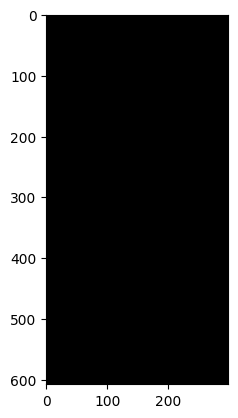

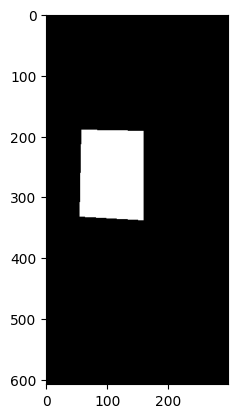

<Figure size 640x480 with 0 Axes>

In [7]:
def find_surface_and_complement(img_shape, contour):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    plt.imshow(mask,cmap="gray")
    cv2.fillPoly(mask, np.array([contour]), 255)
    plt.figure()
    plt.imshow(mask,cmap="gray")
    surface_pixels = np.column_stack(np.where(mask == 255))
    complement_pixels = np.column_stack(np.where(mask == 0))

    return surface_pixels, complement_pixels

pixels_rev=np.array([[pix[1],pix[0]] for pix in pixels])

cible, source = find_surface_and_complement(img.shape,pixels_rev)
img_in_progress = img_gray.copy()
img_in_progress = img_in_progress
filled = np.zeros(img_in_progress.shape, dtype=bool)
for pix in source:
    filled[pix[0],pix[1]]=True
for pix in cible:
    img_in_progress[pix[0],pix[1]] = 0
contour = pixels
data_coeff = {}
plt.figure()

### 1a Caclul du front à chaque itération

In [8]:
def calculer_front():
    hauteur, largeur = filled.shape
    contour = []

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for i in range(hauteur):
        for j in range(largeur):
            if filled[i, j] == False:
                for di, dj in directions:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < hauteur and 0 <= nj < largeur:
                        if filled[ni, nj] ==True:
                            contour.append([i,j])
                            break

    return np.array(contour)

### 1.b Calcul des priorités pour le contour

#### Calcul de la confiance pour un pixel $p$ donné et fonction de mise à jour pour le contour

In [9]:
def init_confidence(source,priority):
    for pix in source:
            priority[pix[0],pix[1]] = 1
    return "Pixel source initialisés à 1"

def maj_confidence_pix(y,x,taille_patch,confidence):
    new_p = 0
    hauteur, largeur = confidence.shape
    tp2 = taille_patch//2
    tpcar = taille_patch**2
    for xprime in range(max(0,x - tp2),min(largeur,x+tp2+1)):
        for yprime in range(max(y - tp2,0),min(y+tp2+1,hauteur)):
            new_p += confidence[yprime,xprime]
    confidence[y,x] = new_p / (tpcar)
    return

def maj_confidence_contour(contour,taille_patch,confidence):
    for pix in contour:
        y,x = pix[0],pix[1]
        maj_confidence_pix(y,x,taille_patch,confidence)
    return "Pixels du contour actualisés"

In [10]:
# Initialisations
taille_patch = 51
confidence = np.zeros(img_gray.shape)
init_confidence(source,confidence)

'Pixel source initialisés à 1'

#### Calcul du data coefficient

In [11]:
def calculer_data(image, pixels):
    image = image.astype(np.int16)
    hauteur, largeur = image.shape
    resultats = {}

    for (y, x) in pixels:
        gradient_x = (image[y, min(x+1, largeur-1)] - image[y, max(x-1, 0)])
        gradient_y = (image[min(y+1, hauteur-1), x] - image[max(y-1, 0), x])

        resultats[(y,x)] = (gradient_x**2 + gradient_y**2)**0.5
        # Ajouter le calcul de la normale (même si cela n'a pas l'air d'influer)
    return resultats

#### Calcul final de la priorité

### 2a Selection du pixel traité et du patch étudié

In [12]:
def get_prior_pixel():
    pix = np.zeros([])
    priomax = float('-inf')
    for pixcand in contour:
        prio_cand = confidence[pixcand[0],pixcand[1]] * data_coeff[(pixcand[0],pixcand[1])]
        if prio_cand >= priomax:
            pix = pixcand
    return pix

def get_patch_size(x_patch,y_patch,img):
    hauteur, largeur = img.shape
    tp2 = taille_patch//2
    x_min = max(0,x_patch-tp2)
    x_max = min(largeur,x_patch+tp2)
    y_min = max(0,y_patch-tp2)
    y_max = min(hauteur,y_patch+tp2)
    return (x_max - x_patch),(x_patch-x_min),(y_max - y_patch),(y_patch-y_min)

### 2b Calcul du meilleur patch

In [13]:
def distance(source,x_patch,y_patch,filled,img):
    tp2 = taille_patch//2
    patch = img[y_patch-tp2:y_patch+tp2+1,x_patch-tp2:x_patch+tp2+1]
    patch = patch.astype(np.int64)
    source = source.astype(np.int64)
    diff = source - patch
    ssd = diff**2
    for i in range(2*tp2+1):
        for j in range(2*tp2+1):
            if not filled[i,j]:
                ssd[i,j] = 0
    res = np.sum(ssd)
    return res

def distance2(source,x_patch,y_patch,filled,img):
    tp2 = taille_patch//2
    hauteur,largeur = img.shape
    patch = img[y_patch-tp2:y_patch+tp2+1,x_patch-tp2:x_patch+tp2+1]
    res = 0
    for i in range(2*tp2+1):
        for j in range(2*tp2+1):
            if filled[i,j]:
                res += (source[i,j] - patch[i,j])**2
    print("Patch : ", patch)
    print("Source : ", source)
    print("Filled : ", filled)
    print(res)
    return res

In [14]:
def is_in_source(filled_cropped):
    for el in filled_cropped:
        for el2 in el:
            if not el2:
                return False
    return True

In [15]:
def get_best_patch(img,x_patch,y_patch):
    hauteur, largeur = img.shape
    distancemin = float('inf')
    tp2 = taille_patch//2
    x_opt, y_opt = taille_patch, taille_patch
    x_min,x_max = tp2,largeur-tp2
    y_min,y_max = tp2,hauteur-tp2
    filled_cropped_patch = filled[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    for y in range(y_min,y_max):
        for x in range(x_min,x_max):
            source = img[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            filled_cropped = filled[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            if is_in_source(filled_cropped):
                distance_cand = distance(source,x_patch,y_patch,filled_cropped_patch,img)
                if distance_cand < distancemin:
                    x_opt,y_opt = x,y
                    distancemin = distance_cand
    print(x_opt,y_opt)
    print(distancemin)
    return x_opt,y_opt

### 2b. / 3. Copie du patch et mise a jour des pixels remplis

In [16]:
def copie(x_source,y_source,x_patch,y_patch,img):
    tp2 = taille_patch//2
    nmb = 0
    for i in range(-tp2,tp2+1):
        for j in range(-tp2,tp2+1):
            if (not filled[y_patch+i,x_patch + j]):
                nmb+=1
                img[y_patch + i,x_patch + j] = img[y_source + i,x_source+j]
                confidence[y_patch + i,x_patch +j]=confidence[y_patch,x_patch]
                np.append(source,[y_patch,x_patch])
                filled[y_patch + i,x_patch + j] = True
    print("Nombre de pixels copiés",nmb)

# Algorithme final

In [13]:
while filled[filled==False].shape[0] !=0:
    t1 = time.time()
    maj_confidence_contour(contour,taille_patch,confidence)
    print("Après calcul de confidence =",time.time()-t1)
    t2 = time.time()
    data_coeff = calculer_data(img_gray,contour)
    print("Après calcul du data =",time.time()-t2)
    t3 = time.time()
    pix = get_prior_pixel()
    print("Après calcul du pixel traité =",time.time()-t3)
    t4 = time.time()
    y_patch,x_patch = pix[0],pix[1]
    x_opt, y_opt=get_best_patch(img_in_progress,x_patch,y_patch)
    print("Après calcul du meilleur patch =",time.time()-t4)
    t5 = time.time()
    copie(x_opt,y_opt,x_patch,y_patch,img_in_progress)
    print("Après copie =",time.time()-t5)
    t6 = time.time()
    print("nombre de pixels non-traités :",filled[filled==False].shape[0])
    contour=calculer_front()
    print("Après calcul du front =",time.time()-t6)

Après calcul de confidence = 0.09280061721801758
Après calcul du data = 0.002193927764892578
Après calcul du pixel traité = 0.00017595291137695312
305 595
3611
Après calcul du meilleur patch = 148.8573477268219
Nombre de pixels copiés 1006
Après copie = 0.677372932434082
nombre de pixels non-traités : 8778
Après calcul du front = 0.491077184677124
Après calcul de confidence = 0.14717507362365723
Après calcul du data = 0.002975940704345703
Après calcul du pixel traité = 0.00044989585876464844
563 886
7419
Après calcul du meilleur patch = 121.94614100456238
Nombre de pixels copiés 324
Après copie = 0.21329879760742188
nombre de pixels non-traités : 8454
Après calcul du front = 0.47672295570373535
Après calcul de confidence = 0.1312110424041748
Après calcul du data = 0.0016169548034667969
Après calcul du pixel traité = 0.00022721290588378906
258 619
7003
Après calcul du meilleur patch = 148.1352870464325
Nombre de pixels copiés 1013
Après copie = 0.6535019874572754
nombre de pixels non-tr

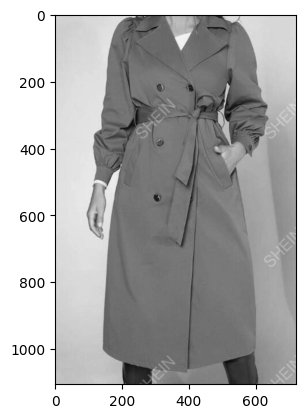

In [14]:
plt.imshow(img_in_progress,cmap="gray")
# cv2.circle(img_in_progress,(184,231),10,255)
#plt.figure()
#plt.imshow(img_in_progress)

In [15]:
cv2.imwrite("image_shein_inapinté.jpeg",img_in_progress)

True

: 

In [129]:
# print(cible)
filled_crop = filled[300:300+taille_patch,200:200+taille_patch]
filled_crop[filled_crop==False].shape

(0,)

In [193]:
print(distance(img_in_progress[230-taille_patch//2:230+taille_patch//2+1,220-taille_patch//2:220+taille_patch//2+1],147,330,filled[230-taille_patch//2:230+taille_patch//2+1,220-taille_patch//2:220+taille_patch//2+1],img_in_progress))
print(distance(img_in_progress[500-taille_patch//2:500+taille_patch//2+1,200-taille_patch//2:200+taille_patch//2+1],200,350,filled[300-taille_patch//2:300+taille_patch//2+1,200-taille_patch//2:200+taille_patch//2+1],img_in_progress))

8920
1240870


In [275]:
maj_confidence_contour(contour,taille_patch,confidence)
data_coeff = calculer_data(img_gray,contour)
pix = get_prior_pixel()

In [276]:
print(pix)

[331  85]


In [277]:
get_best_patch(img_in_progress,85,331)

270 201
88


(270, 201)

In [196]:
print(contour)

[[204 204]
 [204 205]
 [204 206]
 [204 207]
 [204 208]
 [204 209]
 [204 210]
 [204 211]
 [204 212]
 [204 213]
 [204 214]
 [204 215]
 [204 216]
 [204 217]
 [204 218]
 [204 219]
 [204 220]
 [204 221]
 [204 222]
 [204 223]
 [204 224]
 [204 225]
 [204 226]
 [204 227]
 [204 228]
 [204 229]
 [204 230]
 [204 231]
 [204 232]
 [204 233]
 [204 234]
 [204 235]
 [204 236]
 [204 237]
 [204 238]
 [204 239]
 [204 240]
 [204 241]
 [204 242]
 [205 204]
 [205 243]
 [206 204]
 [206 243]
 [207 204]
 [207 244]
 [208 204]
 [208 244]
 [209 203]
 [209 245]
 [210 203]
 [210 245]
 [211 203]
 [211 246]
 [212 203]
 [212 246]
 [213 203]
 [213 247]
 [214 203]
 [214 247]
 [215 203]
 [215 248]
 [216 203]
 [216 248]
 [217 202]
 [217 249]
 [218 202]
 [218 249]
 [219 202]
 [219 250]
 [220 202]
 [220 250]
 [221 202]
 [221 251]
 [222 202]
 [222 251]
 [223 202]
 [223 252]
 [224 202]
 [224 251]
 [225 202]
 [225 251]
 [226 203]
 [226 250]
 [227 203]
 [227 249]
 [228 203]
 [228 248]
 [229 203]
 [229 248]
 [230 203]
 [230 247]

In [13]:
img = cv2.imread('image_chien.jpeg')

img_cv2_Lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
print("RGB :",img)
print("LAB:",img_cv2_Lab)

#def conversion_RGB_CIE(img):
    #img_CIE = np.zeros_like(img, dtype=float)
    # 

RGB : [[[255 255 245]
  [255 255 245]
  [255 255 247]
  ...
  [255 255 244]
  [255 255 242]
  [255 255 242]]

 [[162 151 137]
  [162 151 137]
  [163 152 138]
  ...
  [156 154 136]
  [160 156 138]
  [158 157 137]]

 [[163 152 132]
  [164 153 133]
  [165 154 134]
  ...
  [157 153 134]
  [162 156 137]
  [161 158 137]]

 ...

 [[132 144 144]
  [130 144 143]
  [129 141 141]
  ...
  [126 139 141]
  [128 141 143]
  [130 143 145]]

 [[128 142 140]
  [123 140 137]
  [121 135 133]
  ...
  [122 137 139]
  [125 141 140]
  [126 142 141]]

 [[124 141 138]
  [121 138 135]
  [117 134 131]
  ...
  [121 136 138]
  [123 139 138]
  [123 139 138]]]
LAB: [[[255 126 133]
  [255 126 133]
  [255 127 132]
  ...
  [255 126 133]
  [254 126 134]
  [254 126 134]]

 [[161 130 137]
  [161 130 137]
  [162 130 137]
  ...
  [162 125 138]
  [164 126 138]
  [164 125 139]]

 [[161 129 140]
  [162 129 140]
  [163 129 140]
  ...
  [161 126 138]
  [164 127 139]
  [166 125 139]]

 ...

 [[150 124 127]
  [150 123 127]
  [147 12

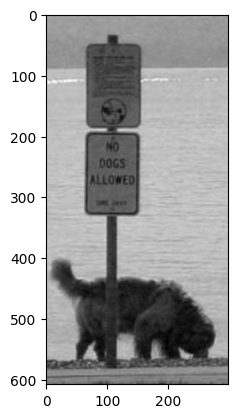

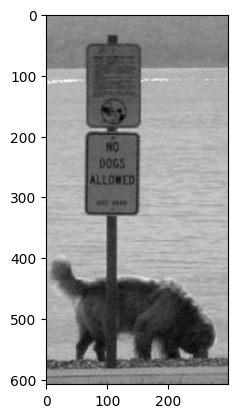

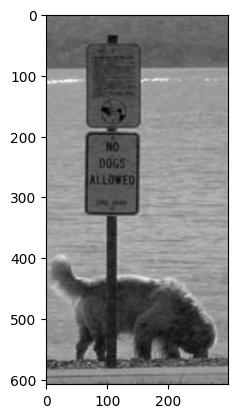

In [24]:
img_rouge = np.zeros(img.shape[:2],dtype=np.int64)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_rouge[i,j] = img[i,j][0]
plt.imshow(img_rouge,cmap="gray")
img_vert = np.zeros(img.shape[:2],dtype=np.int64)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_vert[i,j] = img[i,j][1]
plt.figure()
plt.imshow(img_vert,cmap="gray")
img_bleu = np.zeros(img.shape[:2],dtype=np.int64)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_bleu[i,j] = img[i,j][2]
plt.figure()
plt.imshow(img_bleu,cmap="gray")

In [31]:
filled = np.zeros(img.shape[:2],dtype = bool)
for i in range(filled.shape[0]):
    for j in range(filled.shape[1]):
        filled[i,j]=True
print(filled)
taille_patch = 9
print(distance(img[230-taille_patch//2:230+taille_patch//2+1,220-taille_patch//2:220+taille_patch//2+1],147,330,filled[230-taille_patch//2:230+taille_patch//2+1,220-taille_patch//2:220+taille_patch//2+1],img))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
1113580
